# Prediction of Maize rhizosphere microbiome in novel ecoystems

In [39]:
#nbi:hide_in

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from ipywidgets import interact, widgets
import nbinteract as nbi
import rpy2.rinterface

In [40]:
#nbi:hide_in
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
%reload_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


#### Introduce environmental features values

In [41]:
#nbi:hide_in
# Interface to ask for age, temperature and precipitations3Days (with unit and valid range) 
# https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html#IntSlider

#a = widgets.FloatSlider(min=40,max=100,value=60)
#b = widgets.FloatSlider(min=0,max=5,value=1.5)
#c = widgets.IntSlider(min=1,max=20,value=4)


#accordion = widgets.Accordion(children=[a,b,c])
#accordion.set_title(0, 'Temperature (ºF):')
#accordion.set_title(1, 'Precipitations 3 days (inches):')
#accordion.set_title(2, 'Plant age (weeks):')
#accordion

##out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

#t = widgets.Label(value="Please, select the environmental features associated to the maize plant/soil to what you would like to predict its rhizosphere microbiome:")

#widgets.VBox([t, accordion])




In [42]:
#nbi:hide_in
a = widgets.FloatSlider(description='Temperature',min=40,max=100,value=60)
b = widgets.FloatSlider(description='Rain (3 days)',min=0,max=5,value=1.5)
c = widgets.IntSlider(description='Plant age',min=1,max=20,value=4)
t1 = widgets.Label(value="Please, select the environmental features associated to the maize plant/soil to") 
t2 = widgets.Label(value="what you would like to predict its rhizosphere microbiome:")
ui = widgets.VBox([t1, t2, a, b, c])

display(ui)


In [43]:
#nbi:hide_in
temp=a.value
rain=b.value
age=c.value

In [44]:
#nbi:hide_in
metadata = pd.DataFrame({'X.SampleID': ['new01'], 'age': [age], 'Temperature': [temp], 'Precipitation3Days':[rain]}, 
                  columns=['X.SampleID','age','Temperature','Precipitation3Days'])
metadata = metadata.set_index('X.SampleID')
domain = metadata[['age',
                   'Temperature',
                   'Precipitation3Days']]
domain

,age,Temperature,Precipitation3Days
X.SampleID,,,
new01,4,60.0,1.5


In [45]:
#nbi:hide_in
domain_novel_samples = domain.to_numpy(dtype=np.float32)

#### Load model ...

In [46]:
#nbi:hide_in
decoder = tf.keras.models.load_model('Models/decoder.h5')
encoder_domain = tf.keras.models.load_model('Models/encoder_domain_model_latent.h5')

#### Compute new predictions ...

In [47]:
#nbi:hide_in
# Input only domain (i.e. environmental features)
pred_latent_novel_samples = encoder_domain.predict(domain_novel_samples)
pred_domain_novel_samples = decoder.predict(pred_latent_novel_samples)

In [48]:
#nbi:hide_in
def save_predicted_otu_table(pred,sample_names,otu_names,suffix=''):
    df_otu = pd.DataFrame(pred, index=sample_names, columns=otu_names)
    df_otu.T.to_csv('abundances_'+suffix+'.tsv', index=True, header=True, sep='\t')
  
    return df_otu

In [49]:
#nbi:hide_in
# Get otu IDs
otu = pd.read_csv('otu_column_otuids.csv', index_col=0, header=None, sep='\t').T
otu = otu.set_index('otuids')
otuids = otu.columns

In [50]:
#nbi:hide_in
df_pred_otu = save_predicted_otu_table(pred_domain_novel_samples,domain.index,otuids,'predicted_otus_novel_features')

#### Plot new predictions

In [53]:
%Rpush temp rain age
#nbi:hide_in

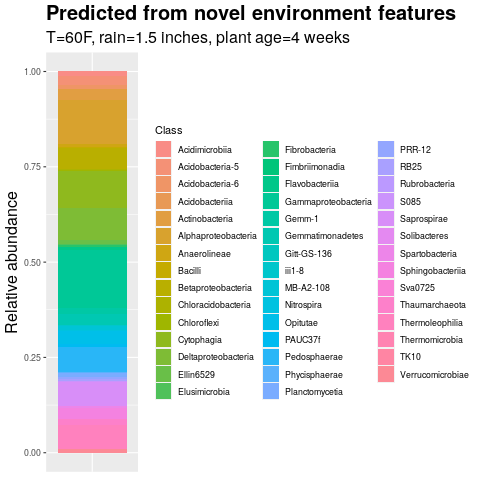

In [54]:
%%R
source('Src/functionsR_plotMicrobiome.r')
physeq_pred = build_physeq_object_otu_tax('abundances_predicted_otus_novel_features.tsv','tax_table_cleanNames.csv')
plot_taxa_agg(physeq_pred,"Class",temp,rain,age)